In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import butter, filtfilt

In [2]:
data_dir = Path("../data/first_dataset_raw")
df_raw=pd.read_csv(data_dir/"BrainFlow-RAW_2025-05-19_22-02-06_79.csv", header=None, sep="\t")

In [5]:
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (359078, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,9664.782544,8370.527133,23299.301958,13937.698476,14454.761381,-3195.830070,4909.158338,-311.002172,0.0,...,104.0,0.0,0.0,16.0,8.0,0.0,0.0,0.0,1.747687e+09,0.0
1,2.0,19343.847852,16753.548891,46601.174367,27883.778856,28910.752107,-6409.340371,9889.283465,-623.144284,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
2,4.0,19340.629201,16741.031914,46604.683590,27885.879920,28939.384692,-6358.221931,9841.718953,-631.861464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
3,6.0,19339.198689,16740.495472,46599.006247,27878.213272,28911.780287,-6401.763129,9834.991078,-624.641851,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.747687e+09,0.0
4,8.0,19340.182166,16742.752998,46605.935288,27887.757467,28924.520782,-6387.033330,9888.143526,-626.251176,0.0,...,112.0,0.0,8.0,16.0,24.0,0.0,0.0,0.0,1.747687e+09,0.0


In [6]:
df_raw.iloc[:, 1].describe()

count    359078.000000
mean      22144.245719
std        1119.423070
min        9664.782544
25%       21272.825750
50%       22143.470900
75%       23062.054954
max       24508.821906
Name: 1, dtype: float64

In [7]:
cols_to_drop = list(range(9, 11)) + list(range(17, 30))
df_raw = df_raw.drop(df_raw.columns[cols_to_drop], axis=1)

In [8]:
eeg_labels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2", "F3", "F4", "Fz", "Pz", "P3", "P4"]
col_names = ["sample_index"] + eeg_labels + ["timestamp", "marker"]
df_raw.columns = col_names

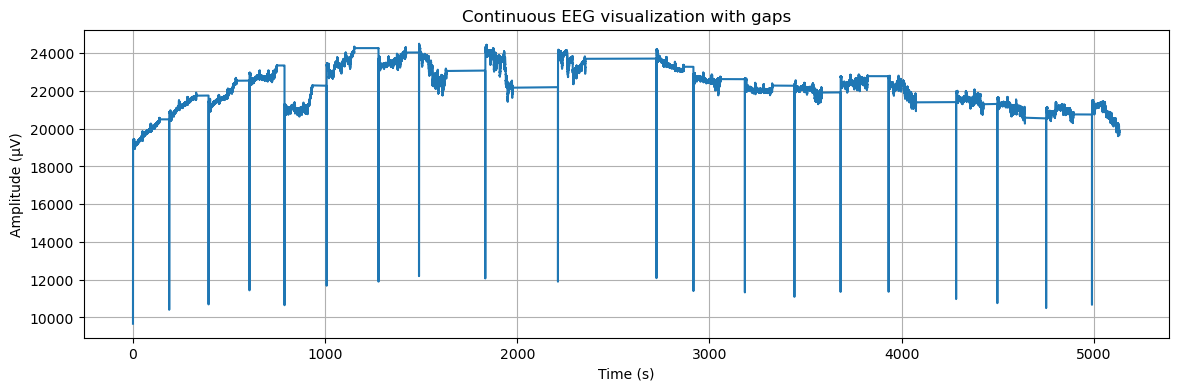

In [9]:
df_raw["time_sec"] = df_raw["timestamp"] - df_raw["timestamp"].iloc[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
plt.plot(df_raw["time_sec"], df_raw.iloc[:, 1])  # channel 0 (Fp1)
plt.title("Continuous EEG visualization with gaps")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()

In [10]:
df_raw["timestamp_diff"] = df_raw["timestamp"].diff()
gap_threshold = 1.0  # seconds
gap_indices = df_raw.index[df_raw["timestamp_diff"] > gap_threshold].tolist()
print(gap_indices)

[17581, 35444, 53701, 71777, 89925, 108181, 126188, 144054, 161919, 179935, 197909, 215733, 233878, 251767, 269641, 287542, 305345, 323361, 341275]


In [11]:
def split_by_timestamp_gap(df, timestamp_col="timestamp", max_gap=1.0):
    df = df.copy()
    df["timestamp_diff"] = df[timestamp_col].diff()
    split_indices = df.index[df["timestamp_diff"] > max_gap].tolist()

    blocks = []
    start = 0
    for idx in split_indices:
        blocks.append(df.iloc[start:idx].reset_index(drop=True))
        start = idx
    blocks.append(df.iloc[start:].reset_index(drop=True))

    return blocks

In [12]:
blocks = split_by_timestamp_gap(df_raw, max_gap=1.0)

print(f"Number of detected blocks: {len(blocks)}")
for i, b in enumerate(blocks):
    duration = b["timestamp"].iloc[-1] - b["timestamp"].iloc[0]
    print(f"Block {i+1}: {len(b)} samples | {duration:.2f} s")


Number of detected blocks: 20
Block 1: 17581 samples | 140.57 s
Block 2: 17863 samples | 142.92 s
Block 3: 18257 samples | 146.04 s
Block 4: 18076 samples | 144.59 s
Block 5: 18148 samples | 145.16 s
Block 6: 18256 samples | 146.06 s
Block 7: 18007 samples | 144.08 s
Block 8: 17866 samples | 142.91 s
Block 9: 17865 samples | 142.95 s
Block 10: 18016 samples | 144.16 s
Block 11: 17974 samples | 143.79 s
Block 12: 17824 samples | 142.58 s
Block 13: 18145 samples | 145.17 s
Block 14: 17889 samples | 143.11 s
Block 15: 17874 samples | 142.99 s
Block 16: 17901 samples | 143.25 s
Block 17: 17803 samples | 142.44 s
Block 18: 18016 samples | 144.15 s
Block 19: 17914 samples | 143.31 s
Block 20: 17803 samples | 142.46 s


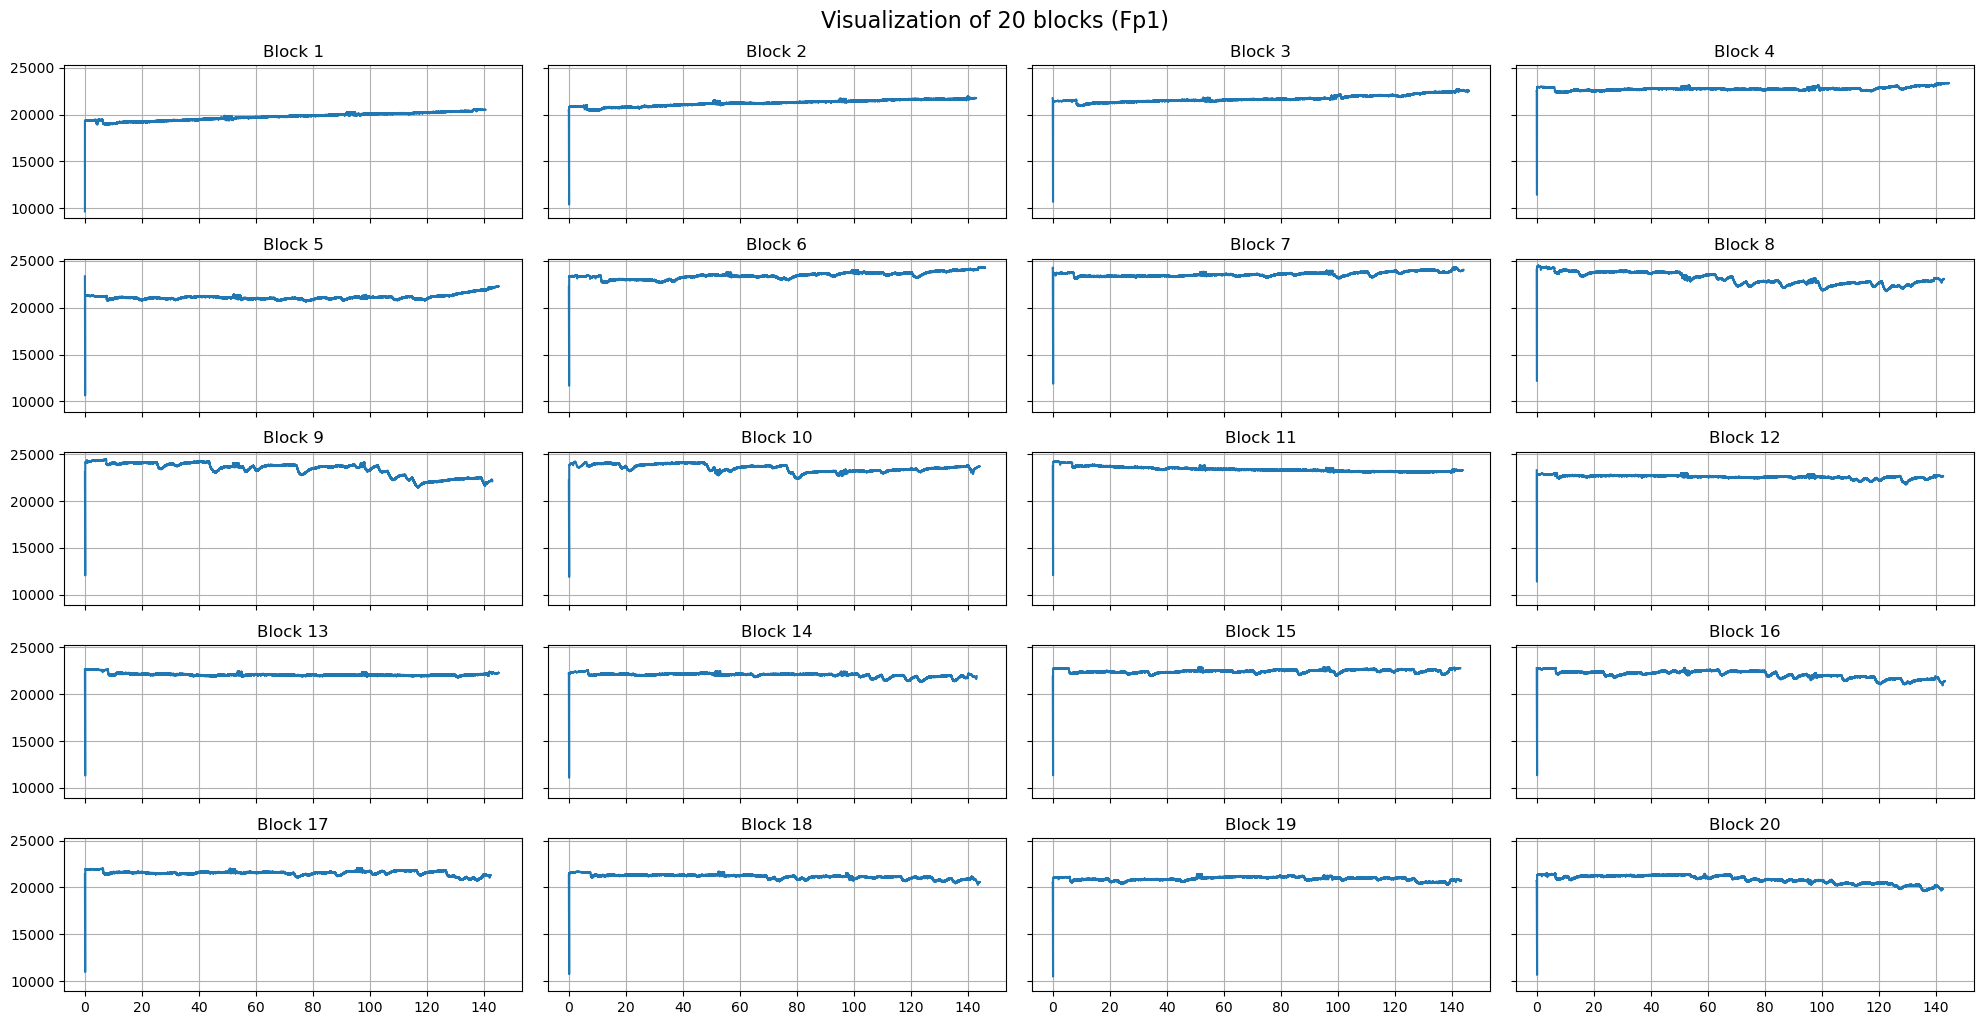

In [13]:
fig, axs = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, df_block in enumerate(blocks):
    df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]
    axs[i].plot(df_block["time_sec"], df_block["Fp1"])
    axs[i].set_title(f"Block {i+1}")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Visualization of 20 blocks (Fp1)", fontsize=16, y=1.02)
plt.show()

In [14]:
def trim_block_by_timestamp(df, start_trim=7, end_trim=3):
    df = df.copy()
    start_time = df["timestamp"].iloc[0] + start_trim
    end_time = df["timestamp"].iloc[-1] - end_trim
    return df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)].reset_index(drop=True)

In [15]:
trimmed_blocks = [trim_block_by_timestamp(b) for b in blocks]

In [17]:
for i, b in enumerate(trimmed_blocks):
    dur = b["timestamp"].iloc[-1] - b["timestamp"].iloc[0]
    print(f"Block {i+1}: {dur:.2f} s")


Block 1: 130.56 s
Block 2: 132.90 s
Block 3: 136.03 s
Block 4: 134.58 s
Block 5: 135.16 s
Block 6: 136.05 s
Block 7: 134.07 s
Block 8: 132.90 s
Block 9: 132.94 s
Block 10: 134.15 s
Block 11: 133.77 s
Block 12: 132.57 s
Block 13: 135.17 s
Block 14: 133.10 s
Block 15: 132.98 s
Block 16: 133.23 s
Block 17: 132.43 s
Block 18: 134.14 s
Block 19: 133.30 s
Block 20: 132.45 s


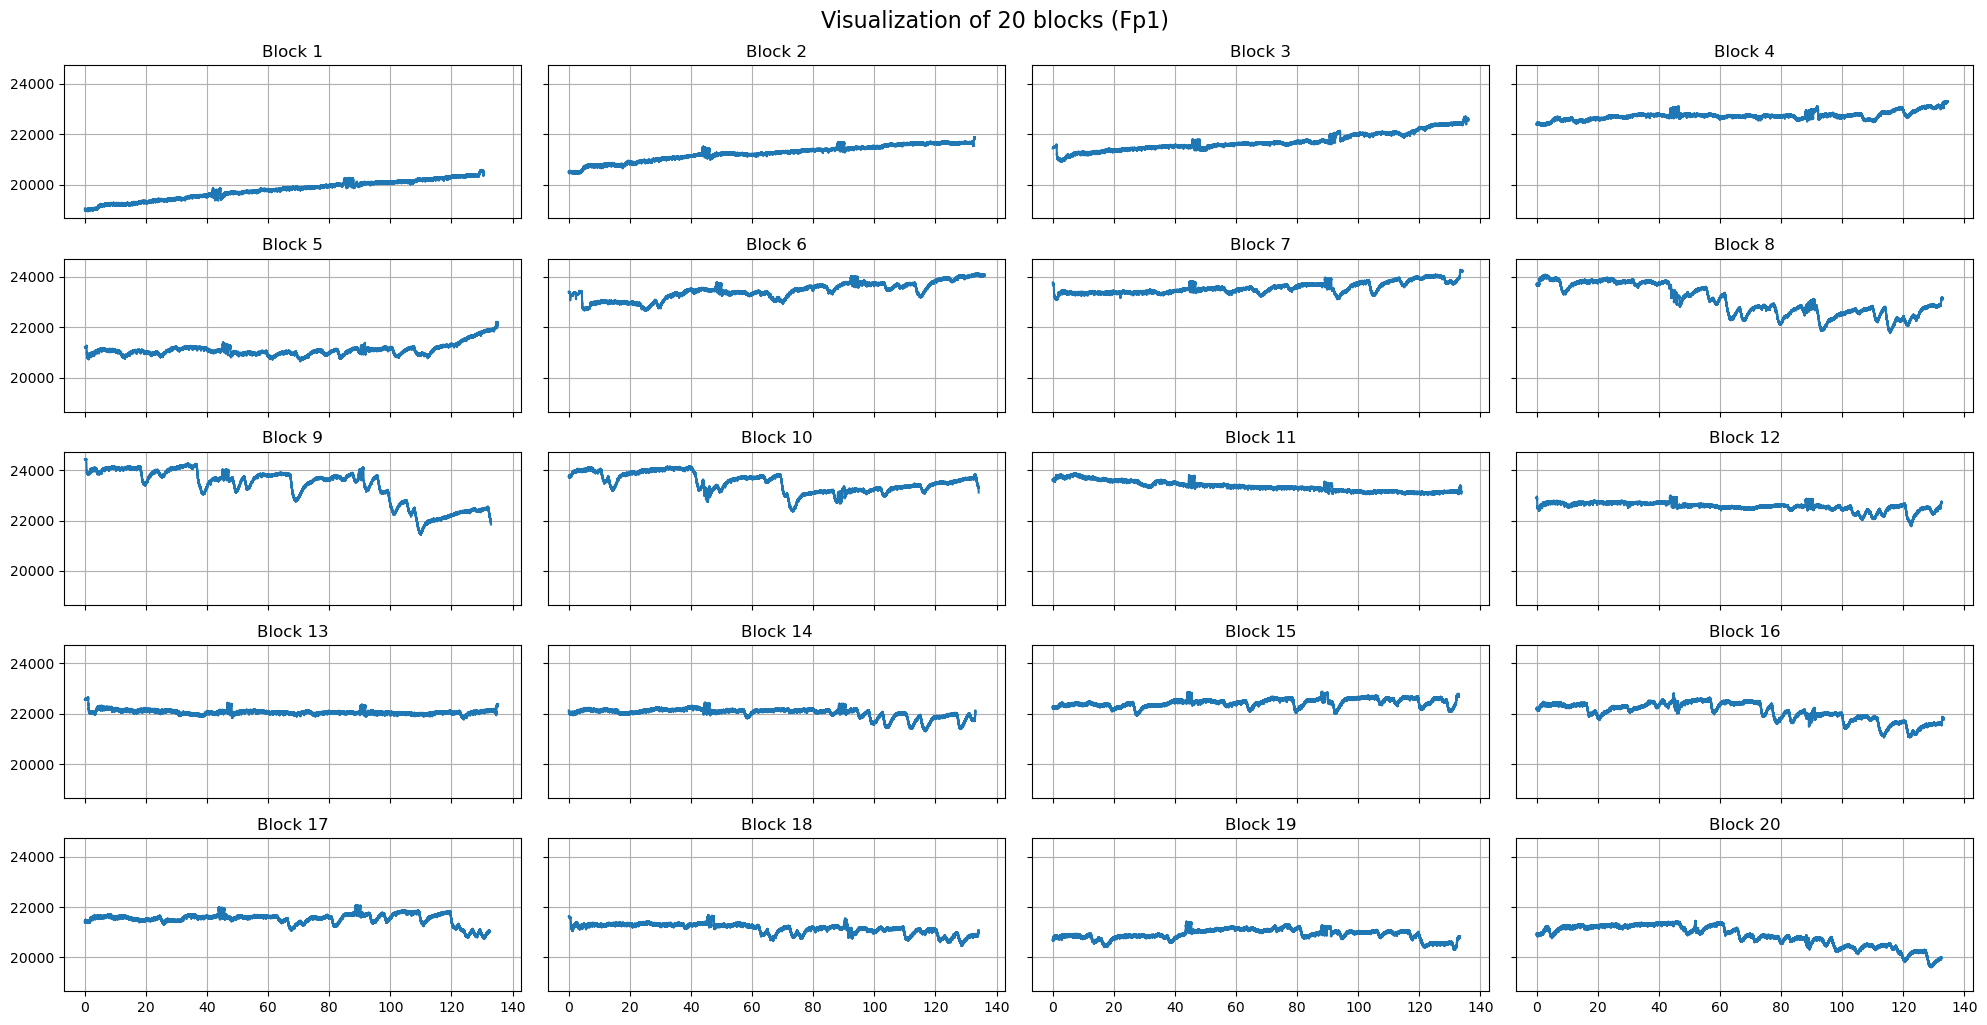

In [18]:
fig, axs = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, df_block in enumerate(trimmed_blocks):
    df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]
    axs[i].plot(df_block["time_sec"], df_block["Fp1"])
    axs[i].set_title(f"Block {i+1}")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Visualization of 20 blocks (Fp1)", fontsize=16, y=1.02)
plt.show()

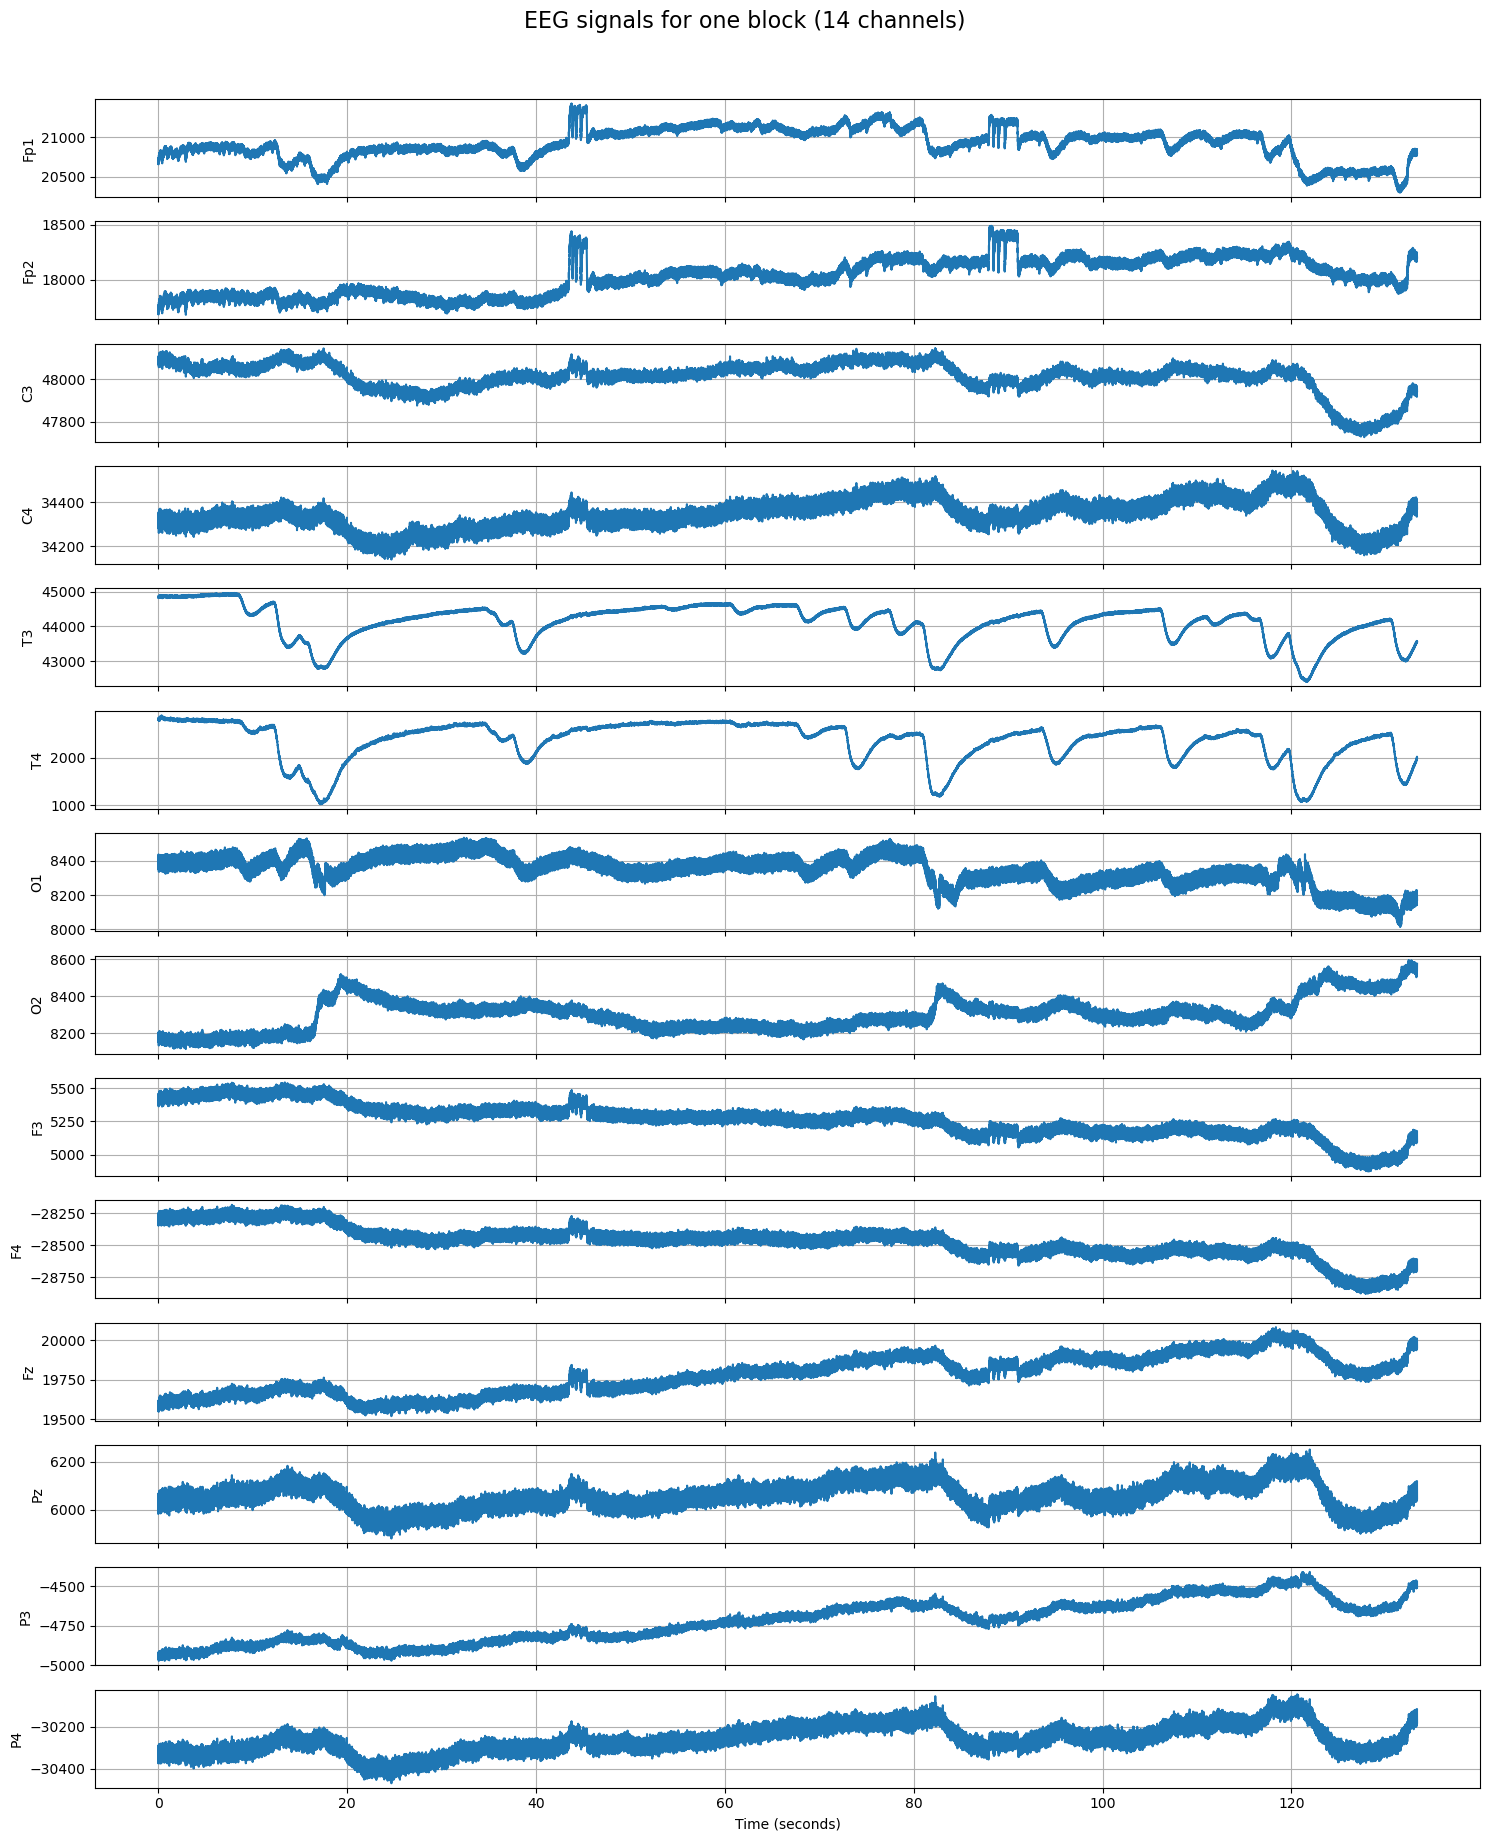

In [19]:
df_block = trimmed_blocks[18]

# Cria coluna de tempo relativo (em segundos)
df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]

eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]

fig, axs = plt.subplots(len(eeg_channels), 1, figsize=(15, 18), sharex=True)
for i, ch in enumerate(eeg_channels):
    axs[i].plot(df_block["time_sec"], df_block[ch])
    axs[i].set_ylabel(ch)
    axs[i].grid(True)

axs[-1].set_xlabel("Time (seconds)")
plt.suptitle("EEG signals for one block (14 channels)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


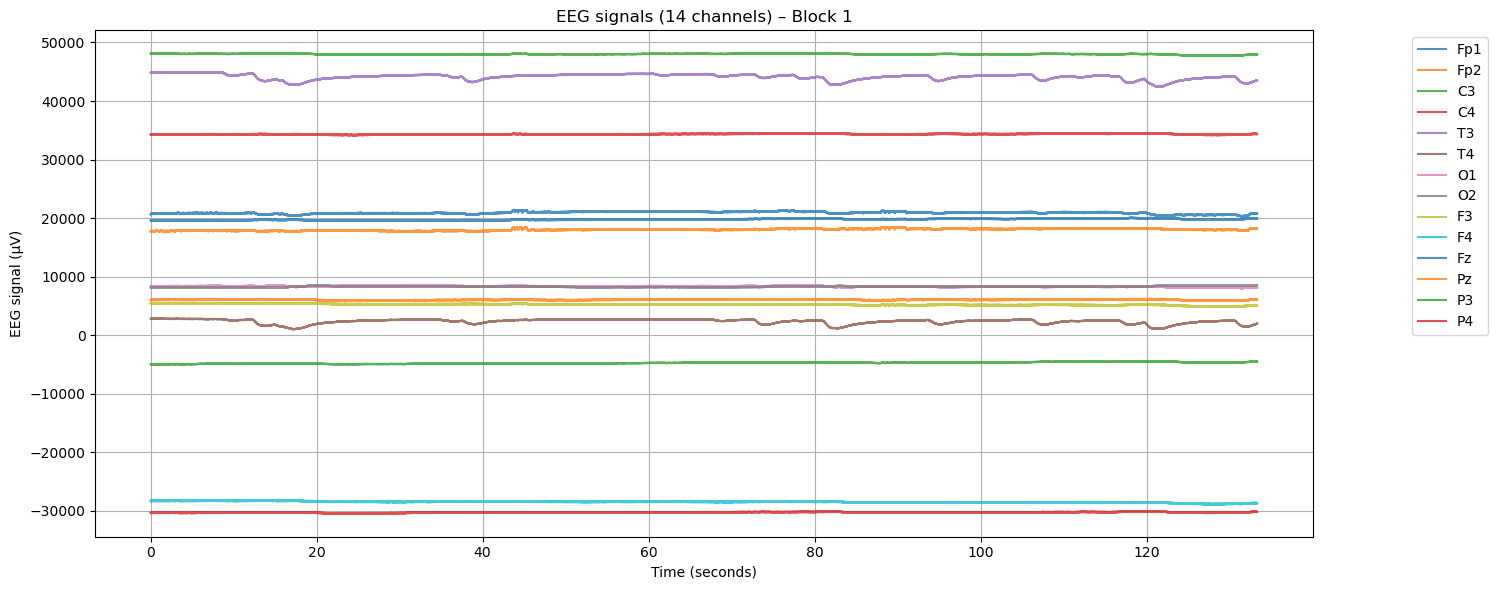

In [32]:
df_block = trimmed_blocks[18]  # Change index according to desired block

# Create relative time column (in seconds)
df_block["time_sec"] = df_block["timestamp"] - df_block["timestamp"].iloc[0]

# List of 14 EEG channels
eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]

# Plot
plt.figure(figsize=(15, 6))
for ch in eeg_channels:
    plt.plot(df_block["time_sec"], df_block[ch], label=ch, alpha=0.8)

plt.title("EEG signals (14 channels) – Block 1")
plt.xlabel("Time (seconds)")
plt.ylabel("EEG signal (µV)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


## SNR – Signal-to-Noise Ratio

SNR (Signal-to-Noise Ratio) is a metric that measures how strong the desired signal is compared to the noise present in the data.

$$
SNR(dB) = 10 * log_{10}\frac{Signal Power}{Noise Power}
$$

- If the signal is much larger than the noise → High SNR (good)
- If the noise is larger or comparable to the signal → Low SNR (bad)

SNR can be measured in absolute units (simple ratio) or in decibels (dB) — which is the most common form.

### SNR in the EEG context

The challenge:
In EEG, the true brain signal is very weak (microvolts) and mixed with noise from various sources:

- Eye blinks, muscle contractions, breathing
- Electrical noise (power outlet, USB cable, Wi-Fi)
- Head movement, poorly placed electrodes

This is why EEG typically has low SNR by nature.

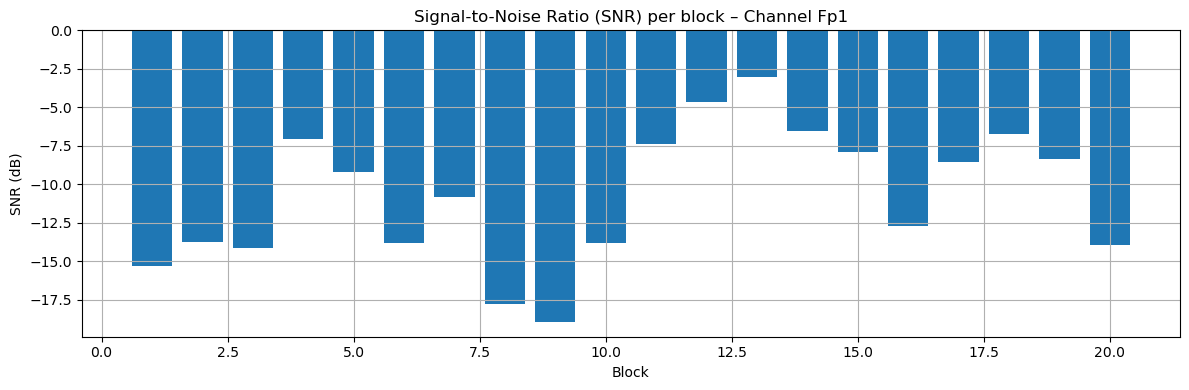

In [33]:
# Force all blocks to have same size (min_len)
fp1_blocks = []
for block in trimmed_blocks:
    if len(block) >= min_len:
        fp1_blocks.append(block["Fp1"].values[:min_len])
    else:
        print("Block size smaller than minimum expected, skipping.")

# Build matrix now without silent error
fp1_array = np.stack(fp1_blocks)

# Mean signal
mean_signal = np.mean(fp1_array, axis=0)

# Signal variance
signal_variance = np.var(mean_signal)

# Noise per block
noise_array = fp1_array - mean_signal
noise_variances = np.var(noise_array, axis=1)

# SNR in dB
snr_per_block = 10 * np.log10(signal_variance / noise_variances)


# Plot
plt.figure(figsize=(12, 4))
plt.bar(range(1, 21), snr_per_block)
plt.xlabel("Block")
plt.ylabel("SNR (dB)")
plt.title("Signal-to-Noise Ratio (SNR) per block – Channel Fp1")
plt.grid(True)
plt.tight_layout()
plt.show()


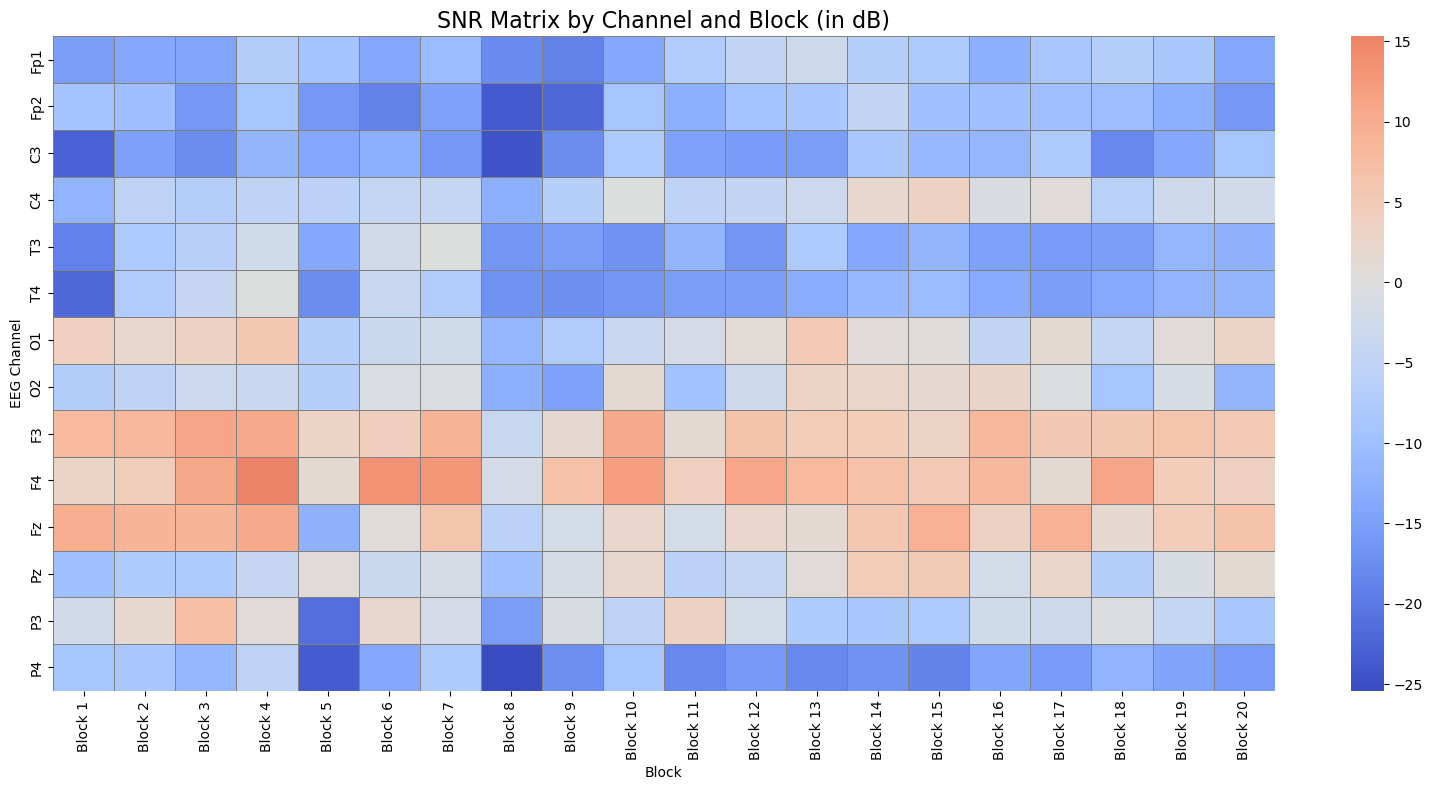

In [35]:
# List of EEG channels to analyze
eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]

# Initialize matrix to store SNRs (channels x blocks)
snr_matrix = np.zeros((len(eeg_channels), len(trimmed_blocks)))

# Find minimum common length
min_len = min(len(block) for block in trimmed_blocks)

# Loop through channels
for ch_idx, ch_name in enumerate(eeg_channels):
    # Extract specific channel from all blocks (with trimming)
    channel_blocks = []
    for block in trimmed_blocks:
        signal = block[ch_name].values
        if len(signal) >= min_len:
            channel_blocks.append(signal[:min_len])
    channel_array = np.stack(channel_blocks)

    # Mean signal for channel
    mean_signal = np.mean(channel_array, axis=0)
    signal_variance = np.var(mean_signal)

    # Noise (difference between each block and mean)
    noise_array = channel_array - mean_signal
    noise_variances = np.var(noise_array, axis=1)

    # SNR in dB
    snrs = 10 * np.log10(signal_variance / noise_variances)
    snr_matrix[ch_idx, :] = snrs

# Convert to DataFrame for easier plotting
df_snr = pd.DataFrame(snr_matrix, index=eeg_channels, columns=[f"Block {i+1}" for i in range(len(trimmed_blocks))])

# Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(df_snr, annot=False, cmap="coolwarm", center=0, linewidths=0.5, linecolor='gray')
plt.title("SNR Matrix by Channel and Block (in dB)", fontsize=16)
plt.xlabel("Block")
plt.ylabel("EEG Channel")
plt.tight_layout()
plt.show()


In [34]:
# Channels with best mean SNR
mean_snr_per_channel = df_snr.mean(axis=1)
top_channels = mean_snr_per_channel.sort_values(ascending=False).head(5)
print("Top 5 most reliable channels (highest mean SNR):")
print(top_channels)


Top 5 most reliable channels (highest mean SNR):
F4    7.112483
F3    5.726465
Fz    3.549940
O1   -0.919786
Pz   -2.414081
dtype: float64


In [40]:
# Band-pass filter: 1–45 Hz
def bandpass_filter(data, lowcut=1.0, highcut=45.0, fs=125.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Notch filter at 50 Hz
from scipy.signal import iirnotch

def notch_filter(data, notch_freq=50.0, fs=125.0, quality=30):
    nyq = 0.5 * fs
    w0 = notch_freq / nyq
    b, a = iirnotch(w0, quality)
    return filtfilt(b, a, data)


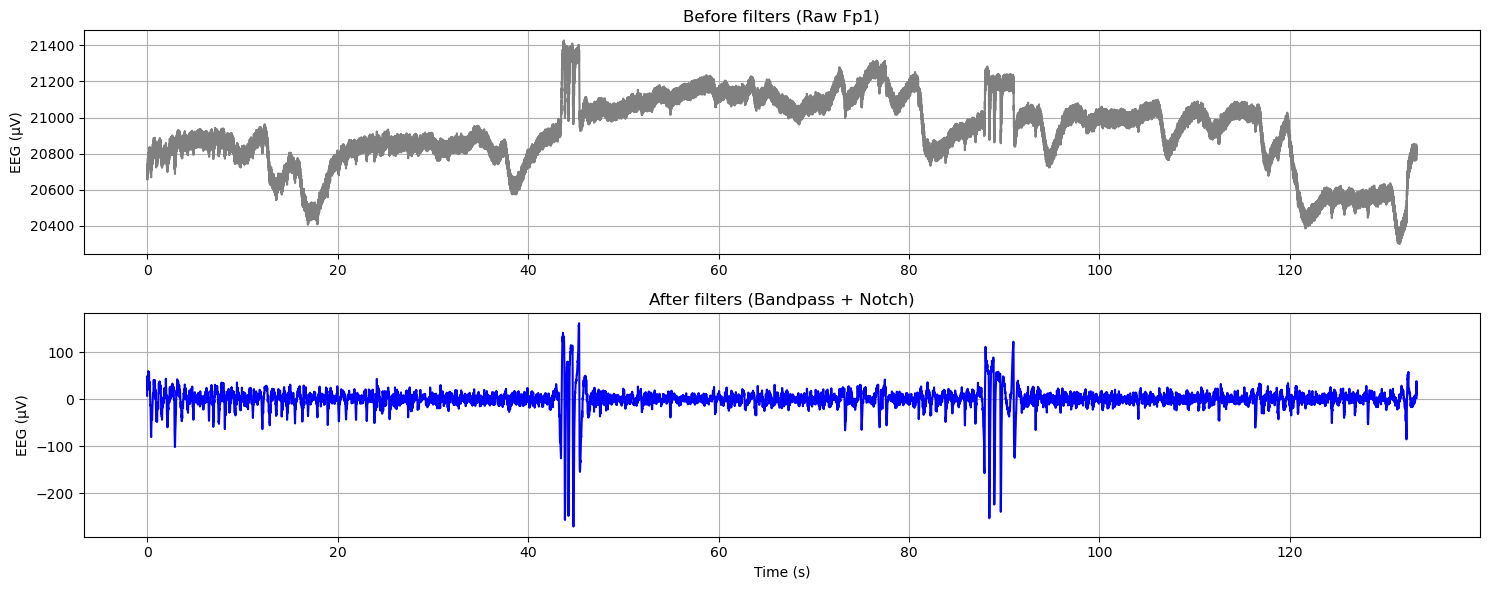

In [ ]:
# Define block and channel
df_block = trimmed_blocks[18]  # choose desired block
raw_signal = df_block["Fp1"].values
time_sec = df_block["timestamp"] - df_block["timestamp"].iloc[0]

# Apply filters
filtered_signal = bandpass_filter(raw_signal)
filtered_signal = notch_filter(filtered_signal)

# Plot
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time_sec, raw_signal, label="Original", color="gray")
plt.title("Before filters (Raw Fp1)")
plt.ylabel("EEG (µV)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_sec, filtered_signal, label="Filtered", color="blue")
plt.title("After filters (Bandpass + Notch)")
plt.xlabel("Time (s)")
plt.ylabel("EEG (µV)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
filtered_blocks = []

# Sampling frequency
fs = 125.0

# List of EEG channels (adjust if needed)
eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]

# Loop through blocks
for df_block in trimmed_blocks:
    df_filt = df_block.copy()
    df_filt["time_sec"] = df_filt["timestamp"] - df_filt["timestamp"].iloc[0]

    # Apply filters to all EEG channels
    for ch in eeg_channels:
        signal = df_filt[ch].values
        filtered = bandpass_filter(signal, lowcut=1.0, highcut=45.0, fs=fs)
        filtered = notch_filter(filtered, notch_freq=50.0, fs=fs)
        df_filt[ch] = filtered

    filtered_blocks.append(df_filt)


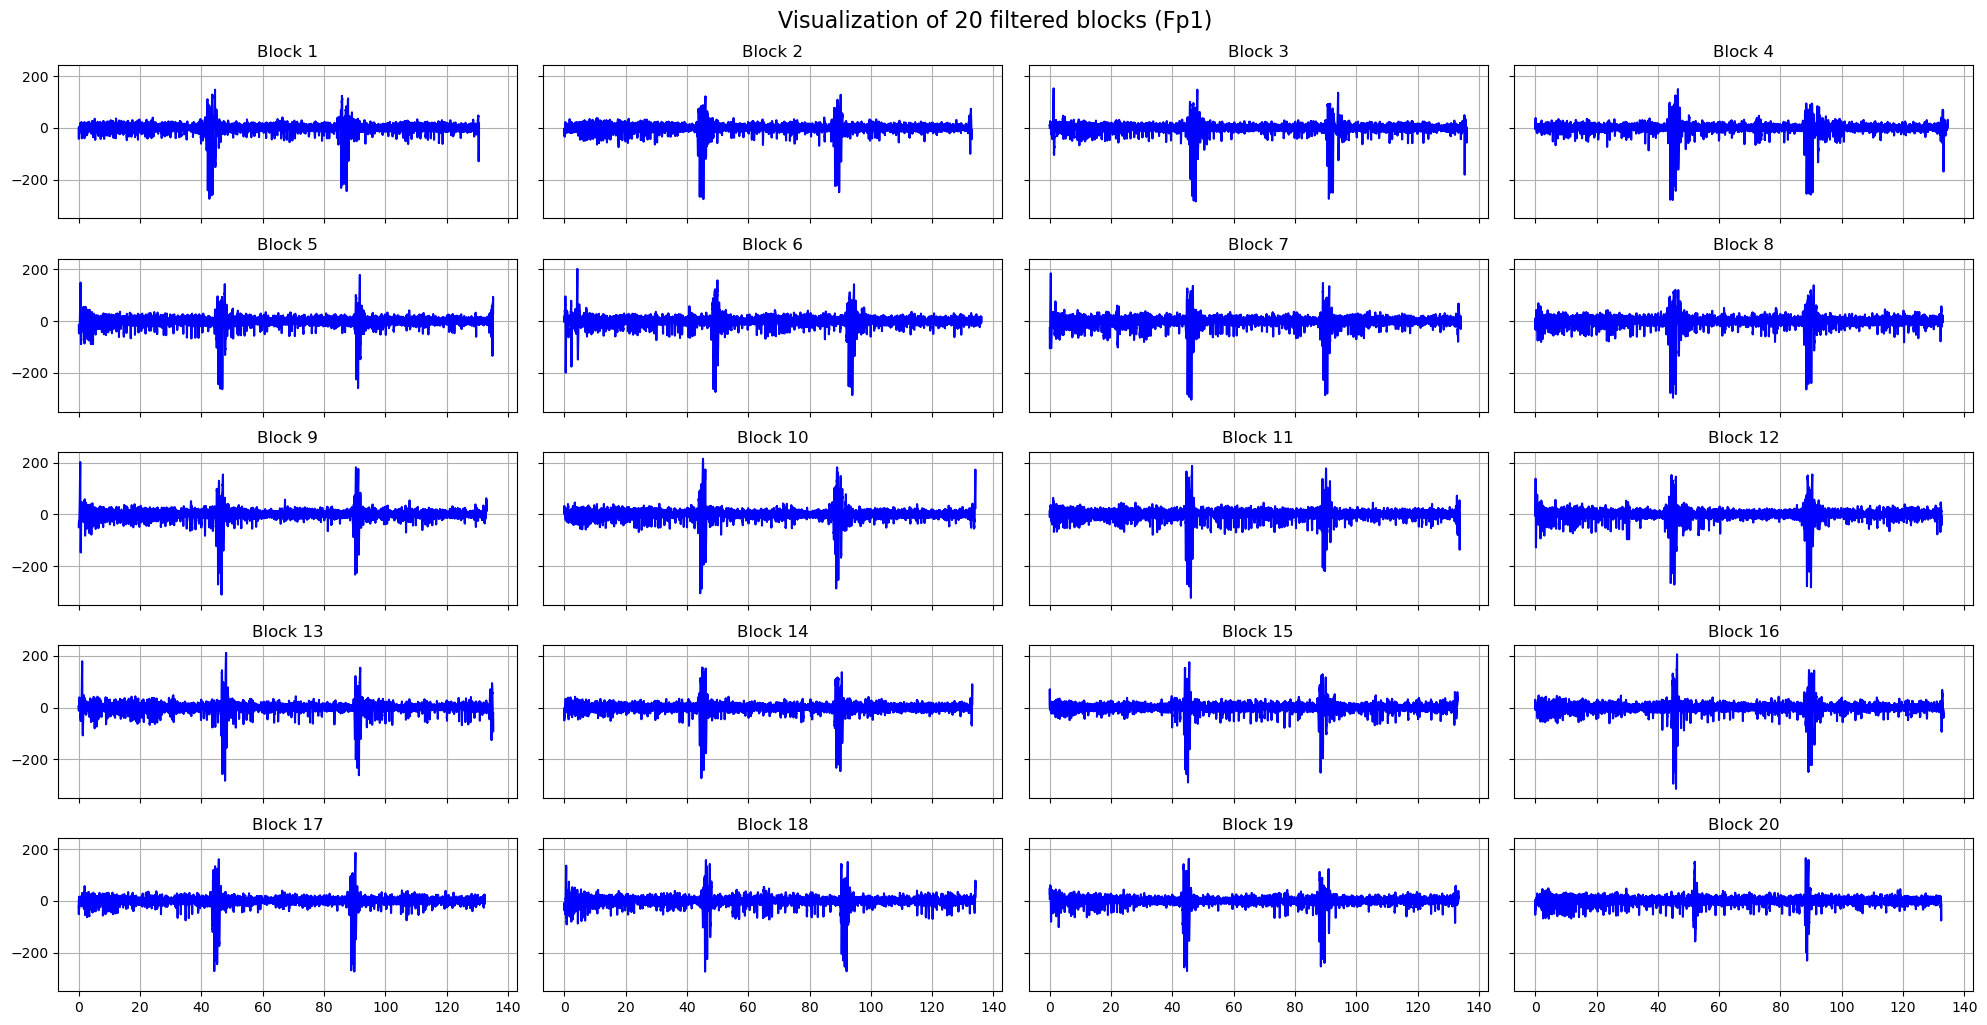

In [47]:
fig, axs = plt.subplots(5, 4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, df_block in enumerate(filtered_blocks):
    axs[i].plot(df_block["time_sec"], df_block["Fp1"], color="blue")
    axs[i].set_title(f"Block {i+1}")
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Visualization of 20 filtered blocks (Fp1)", fontsize=16, y=1.02)
plt.show()


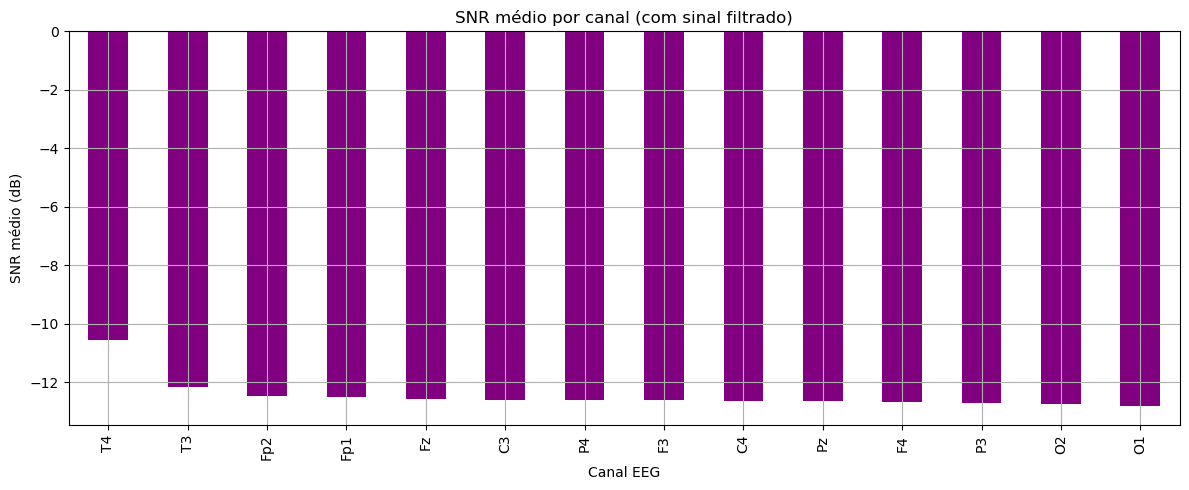

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parâmetros
eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]

fs = 125.0  # Frequência de amostragem
min_len = min(len(df) for df in filtered_blocks)

# Matriz para armazenar SNRs
snr_matrix = np.zeros((len(eeg_channels), len(filtered_blocks)))

# Loop por canal
for ch_idx, ch_name in enumerate(eeg_channels):
    channel_blocks = []

    # Coleta e recorta o canal em todos os blocos
    for df in filtered_blocks:
        signal = df[ch_name].values[:min_len]
        channel_blocks.append(signal)

    channel_array = np.stack(channel_blocks)

    mean_signal = np.mean(channel_array, axis=0)
    signal_variance = np.var(mean_signal)

    noise_array = channel_array - mean_signal
    noise_variances = np.var(noise_array, axis=1)

    snrs = 10 * np.log10(signal_variance / noise_variances)
    snr_matrix[ch_idx, :] = snrs

# DataFrame com média de SNR por canal
snr_avg_per_channel = pd.Series(snr_matrix.mean(axis=1), index=eeg_channels)

# Plot
plt.figure(figsize=(12, 5))
snr_avg_per_channel.sort_values(ascending=False).plot(kind="bar", color="purple")
plt.ylabel("SNR médio (dB)")
plt.xlabel("Canal EEG")
plt.title("SNR médio por canal (com sinal filtrado)")
plt.grid(True)
plt.tight_layout()
plt.show()

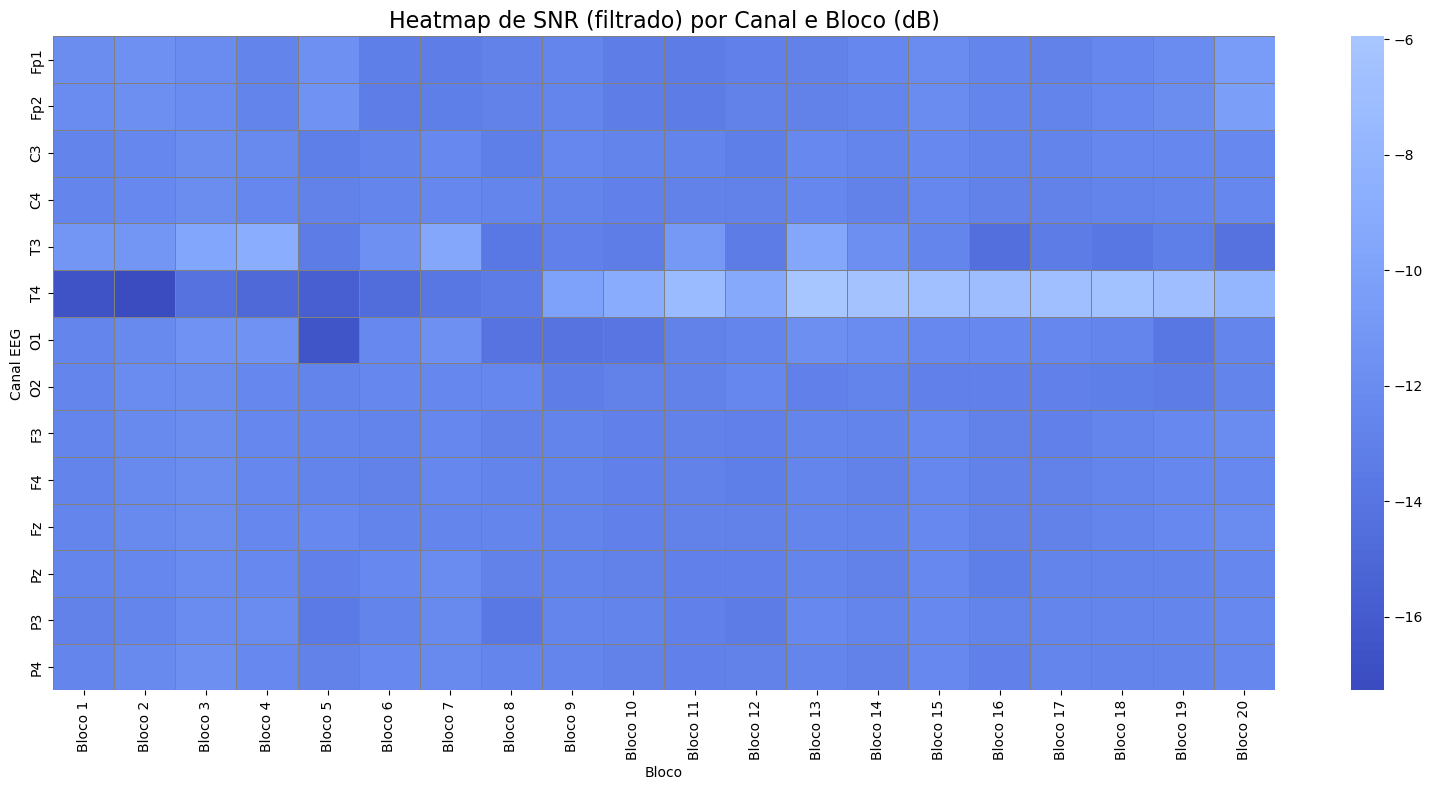

In [49]:
# DataFrame para visualização
df_snr_filtered = pd.DataFrame(snr_matrix, index=eeg_channels, columns=[f"Bloco {i+1}" for i in range(snr_matrix.shape[1])])

# Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(df_snr_filtered, cmap="coolwarm", center=0, linewidths=0.5, linecolor="gray")
plt.title("Heatmap de SNR (filtrado) por Canal e Bloco (dB)", fontsize=16)
plt.xlabel("Bloco")
plt.ylabel("Canal EEG")
plt.tight_layout()
plt.show()

In [51]:
from scipy.signal import welch

def band_power(signal, fs, band):
    fmin, fmax = band
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    band_mask = (freqs >= fmin) & (freqs <= fmax)
    return np.trapz(psd[band_mask], freqs[band_mask])

# Definindo banda alpha
alpha_band = (8, 12)

# Matriz: canais x blocos
snr_alpha_matrix = np.zeros((len(eeg_channels), len(filtered_blocks)))

for ch_idx, ch in enumerate(eeg_channels):
    for b_idx, df in enumerate(filtered_blocks):
        signal = df[ch].values

        # Potência na banda alpha
        alpha_power = band_power(signal, fs, alpha_band)

        # Potência total (1–45 Hz, já filtrado)
        total_power = band_power(signal, fs, (1, 45))

        # "SNR" na banda alpha = proporção da potência alpha sobre total
        snr_alpha_matrix[ch_idx, b_idx] = 10 * np.log10(alpha_power / (total_power - alpha_power + 1e-10))  # evitando div/0


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_19501/1354064196.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


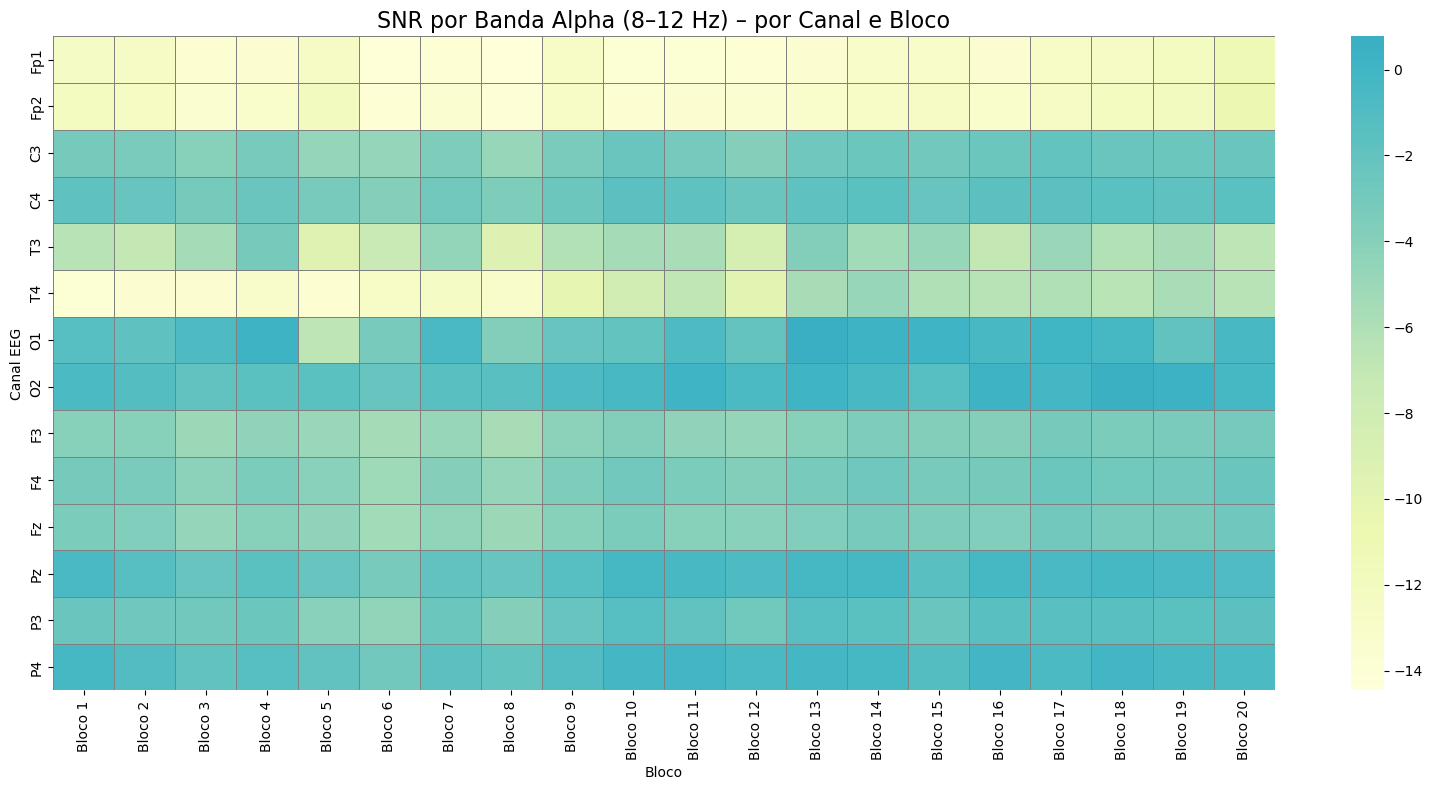

In [54]:
df_snr_alpha = pd.DataFrame(snr_alpha_matrix, index=eeg_channels, columns=[f"Bloco {i+1}" for i in range(snr_alpha_matrix.shape[1])])

plt.figure(figsize=(16, 8))
sns.heatmap(df_snr_alpha, cmap="YlGnBu", center=0, linewidths=0.5, linecolor="gray")
plt.title("SNR por Banda Alpha (8–12 Hz) – por Canal e Bloco", fontsize=16)
plt.xlabel("Bloco")
plt.ylabel("Canal EEG")
plt.tight_layout()
plt.show()


In [53]:
def save_trimmed_blocks(blocks, base_dir):
    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, block in enumerate(blocks, 1):
        filename = f"block_{i:02d}.pkl"
        path = output_dir / filename
        block.to_pickle(path)
        print(f"✅ Block {i} saved at {path}")


In [17]:
clean_dir = data_dir.parent / "first_dataset_trimmed_clean"
save_trimmed_blocks(trimmed_blocks, base_dir=clean_dir)

✅ Block 1 saved at ../raw_data/first_dataset_trimmed_clean/block_01.pkl
✅ Block 2 saved at ../raw_data/first_dataset_trimmed_clean/block_02.pkl
✅ Block 3 saved at ../raw_data/first_dataset_trimmed_clean/block_03.pkl
✅ Block 4 saved at ../raw_data/first_dataset_trimmed_clean/block_04.pkl
✅ Block 5 saved at ../raw_data/first_dataset_trimmed_clean/block_05.pkl
✅ Block 6 saved at ../raw_data/first_dataset_trimmed_clean/block_06.pkl
✅ Block 7 saved at ../raw_data/first_dataset_trimmed_clean/block_07.pkl
✅ Block 8 saved at ../raw_data/first_dataset_trimmed_clean/block_08.pkl
✅ Block 9 saved at ../raw_data/first_dataset_trimmed_clean/block_09.pkl
✅ Block 10 saved at ../raw_data/first_dataset_trimmed_clean/block_10.pkl
✅ Block 11 saved at ../raw_data/first_dataset_trimmed_clean/block_11.pkl
✅ Block 12 saved at ../raw_data/first_dataset_trimmed_clean/block_12.pkl
✅ Block 13 saved at ../raw_data/first_dataset_trimmed_clean/block_13.pkl
✅ Block 14 saved at ../raw_data/first_dataset_trimmed_clean/

In [18]:
def save_trimmed_blocks_csv(blocks, base_dir):
    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, block in enumerate(blocks, 1):
        filename = f"block_{i:02d}.csv"
        path = output_dir / filename
        block.to_csv(path, index=False)
        print(f"Block {i} saved as CSV at {path}")


In [19]:
clean_dir = data_dir.parent / "first_dataset_trimmed_clean"
save_trimmed_blocks_csv(blocks, base_dir=clean_dir)

Block 1 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_01.csv
Block 2 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_02.csv
Block 3 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_03.csv
Block 4 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_04.csv
Block 5 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_05.csv
Block 6 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_06.csv
Block 7 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_07.csv
Block 8 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_08.csv
Block 9 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_09.csv
Block 10 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_10.csv
Block 11 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_11.csv
Block 12 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_12.csv
Block 13 saved as CSV at ../raw_data/first_dataset_trimmed_clean/block_13

In [55]:
def save_filtered_blocks(blocks, base_dir):
    output_dir = Path(base_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, block in enumerate(blocks, 1):
        filename = f"block_{i:02d}.pkl"
        path = output_dir / filename
        block.to_pickle(path)
        print(f"✅ Block {i} saved at {path}")


In [56]:
filtered_dir = data_dir.parent / "first_dataset_initial_filtering"
save_filtered_blocks(filtered_blocks, base_dir=filtered_dir)

✅ Block 1 saved at ../data/first_dataset_initial_filtering/block_01.pkl
✅ Block 2 saved at ../data/first_dataset_initial_filtering/block_02.pkl
✅ Block 3 saved at ../data/first_dataset_initial_filtering/block_03.pkl
✅ Block 4 saved at ../data/first_dataset_initial_filtering/block_04.pkl
✅ Block 5 saved at ../data/first_dataset_initial_filtering/block_05.pkl
✅ Block 6 saved at ../data/first_dataset_initial_filtering/block_06.pkl
✅ Block 7 saved at ../data/first_dataset_initial_filtering/block_07.pkl
✅ Block 8 saved at ../data/first_dataset_initial_filtering/block_08.pkl
✅ Block 9 saved at ../data/first_dataset_initial_filtering/block_09.pkl
✅ Block 10 saved at ../data/first_dataset_initial_filtering/block_10.pkl
✅ Block 11 saved at ../data/first_dataset_initial_filtering/block_11.pkl
✅ Block 12 saved at ../data/first_dataset_initial_filtering/block_12.pkl
✅ Block 13 saved at ../data/first_dataset_initial_filtering/block_13.pkl
✅ Block 14 saved at ../data/first_dataset_initial_filtering/